In [44]:
import pandas
import starepandas
import geopandas
import matplotlib.pyplot as plt
import pystare
import numpy

# Cities

In [45]:
cities = ['Buenos Aires', 'Brasilia', 'Santiago', 
          'Bogota', 'Caracas', 'Sao Paulo', 'Bridgetown']

latitudes = [-34.58, -15.78, -33.45, 4.60, 10.48, -23.55, 13.1]
longitudes = [-58.66, -47.91, -70.66, -74.08, -66.86, -46.63, -59.62]
data =  {'City': cities, 
         'Latitude': latitudes, 'Longitude': longitudes}

cities = starepandas.STAREDataFrame(data)
stare = starepandas.stare_from_xy(cities.Longitude, cities.Latitude, level=27)
geom = geopandas.points_from_xy(cities.Longitude, cities.Latitude, crs='EPSG:4326')
cities.set_stare(stare, inplace=True)
cities.set_geometry(geom, inplace=True)
cities.set_trixels(inplace=True)

# Countries

In [46]:
countries = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
countries = countries.sort_values(by='name')
samerica = countries[countries.continent=='South America']

In [47]:
stare = starepandas.stare_from_gdf(samerica, level=10, force_ccw=True)
samerica = starepandas.STAREDataFrame(samerica, stare=stare)
trixels = samerica.trixels()
samerica.set_trixels(trixels, inplace=True)

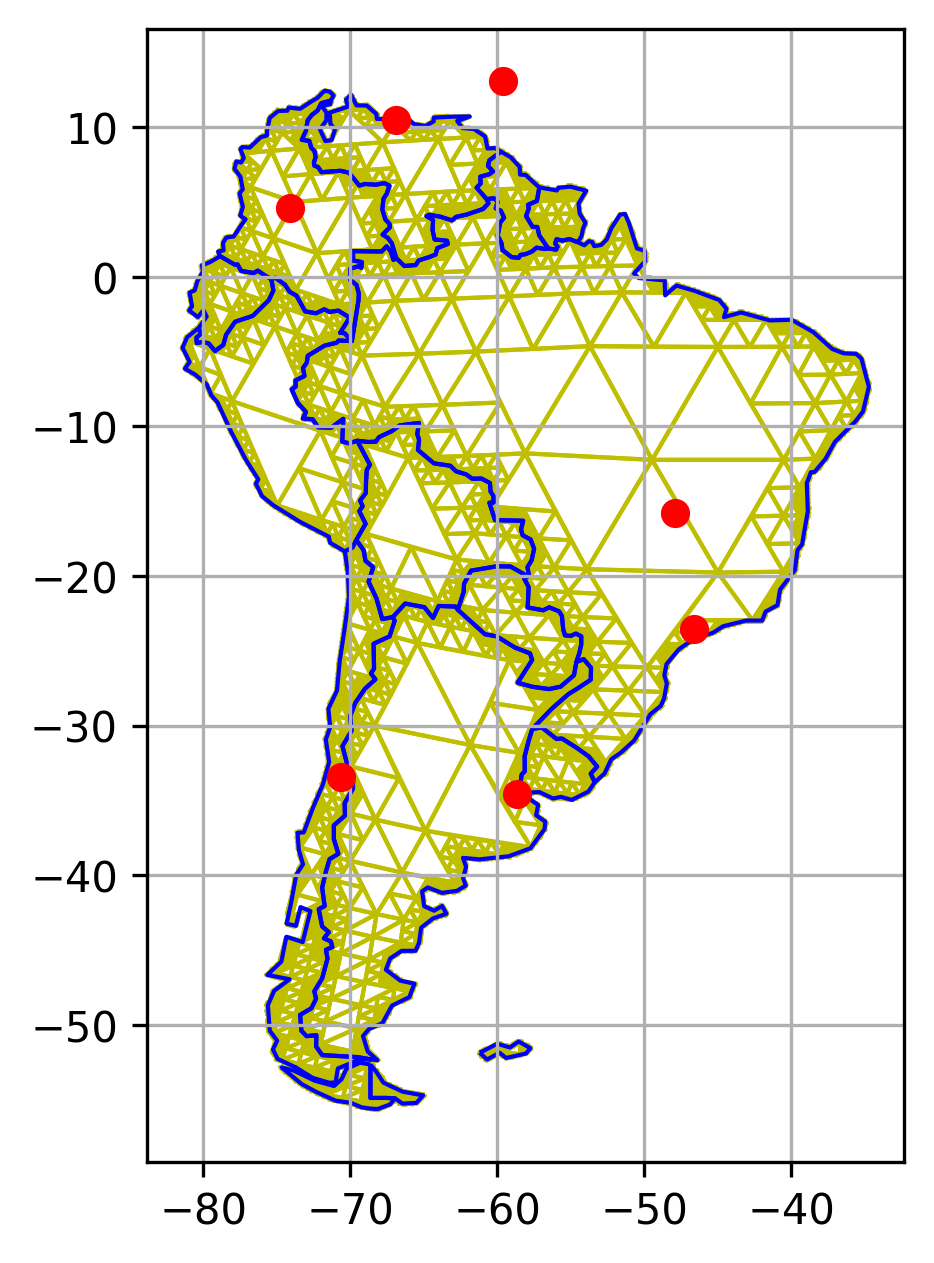

In [49]:
fig, ax = plt.subplots(figsize=(13,5), dpi=300)
ax.grid(True)

samerica.plot(ax=ax, trixels=True, color='y', lw=1, zorder=0)
samerica.plot(ax=ax, trixels=False, facecolor='none', edgecolor='blue', lw=1, zorder=1)
cities.plot(ax=ax, trixels=False, color='r', zorder=2)

fig.savefig('samerica.png')

<AxesSubplot:>

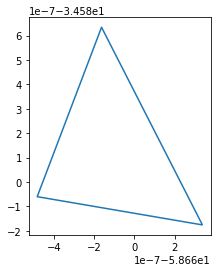

In [6]:
# The cities trixels are too small to be visible, 
# but they do exist:
cities[0:1].plot(trixels=True)

# Intersects

In [7]:
brasilia = cities[cities.City=='Brasilia']

In [8]:
# We do intersect of single feauture and collection; 
# Intersects of two collections only is defined row-wise

# Conventional intersect
intersects_conv = samerica.intersects(brasilia.iloc[0].geometry)

# Stare intersect
intersects_stare = samerica.stare_intersects(brasilia.stare)

intersects_stare

9      False
30     False
29      True
10     False
32     False
44     False
20     False
41     False
156    False
31     False
42     False
28     False
40     False
dtype: bool

In [9]:
samerica.stare_disjoint(brasilia.stare)

9       True
30      True
29     False
10      True
32      True
44      True
20      True
41      True
156     True
31      True
42      True
28      True
40      True
dtype: bool

## With Polygons

In [10]:
# Sao Paulo Sate
fname = 'zip://data/sp_state.zip'
sao_paulo = geopandas.read_file(fname) # Nice flex
sao_paulo = sao_paulo[sao_paulo.mslink==221]
stare = starepandas.stare_from_gdf(sao_paulo, level=10, force_ccw=True)
sao_paulo = starepandas.STAREDataFrame(sao_paulo, stare=stare)

In [11]:
samerica.stare_intersects(sao_paulo.stare.iloc[0])

9      False
30     False
29      True
10     False
32     False
44     False
20     False
41     False
156    False
31     False
42     False
28     False
40     False
dtype: bool

# Intersection

In [51]:
fname = 'zip://data/amapoly_ivb.zip'
amazon = geopandas.read_file(fname) # Nice flex
amazon = amazon.to_crs('EPSG:4326')
amazon['geom_simple'] = amazon.simplify(0.02)
amazon.set_geometry('geom_simple', inplace=True)

stare = starepandas.stare_from_gdf(amazon, level=10, force_ccw=True)
amazon = starepandas.STAREDataFrame(amazon, stare=stare)

trixels = amazon.trixels()
amazon.set_trixels(trixels, inplace=True)

In [52]:
stare_amazon = samerica.stare_intersection(amazon.stare.iloc[0])
samerica['stare_amazon'] = stare_amazon
samerica['trixel_amazon'] = samerica.trixels(stare_column='stare_amazon')

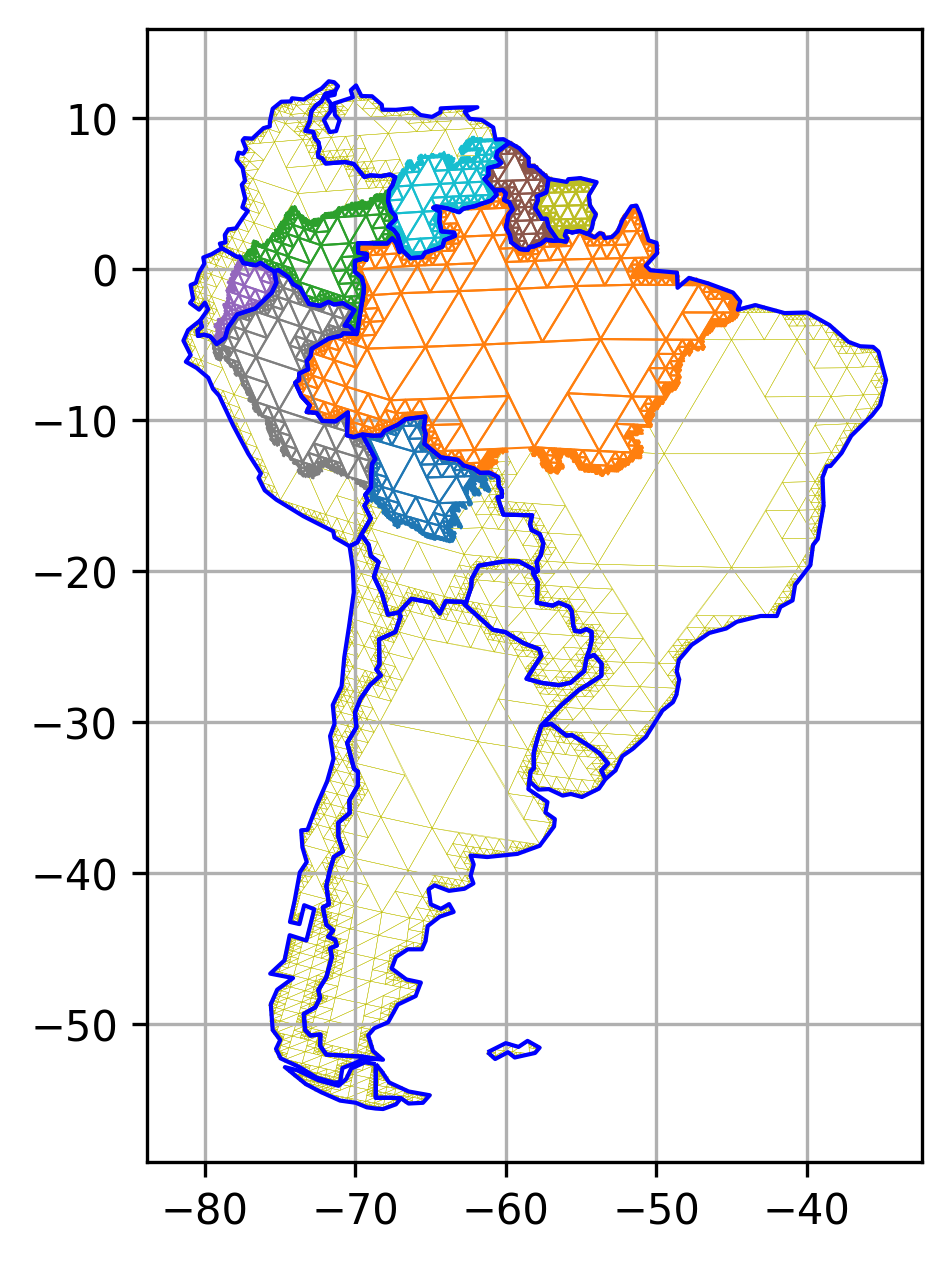

In [53]:
fig, ax = plt.subplots(figsize=(13,5), dpi=300)
ax.grid(True)

samerica.plot(ax=ax, trixels=True, color='y', lw=0.1, zorder=0)
samerica.plot(ax=ax, trixels=False, facecolor='none', edgecolor='blue', lw=1, zorder=4)
df = samerica.set_geometry('trixel_amazon')
df = df[df.geometry.is_empty==False]
df = df.set_geometry(df.geometry.boundary)
df.plot(ax=ax, zorder=3, column='name', lw=0.5)

fig.savefig('amazon.png')